In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# 🐕 End-to-end Multi-class Dog Breed Classification

This notebook builds and end-to-end multi-class image classifier using TensorFLow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.
When I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

Our data is from [Kaggle's dog breed identification competition](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset).

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so we're using  deep learning/transfer learning.
* There are 120 dog breeds.
* There are around 10,000 + images in the trainig set.
* There are around 10,000 + images in the test set

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU




In [ ]:
# Import necessary tools into Colab:

import tensorflow as tf
print("TF version:" , tf.__version__)

import tensorflow_hub as hub
print("TF HUB version:", hub.__version__)


# Checking for GPU availability
print("GPU", "available: YES" if tf.config.list_physical_devices("GPU") else "Not available")

TF version: 2.15.0
TF HUB version: 0.15.0
GPU Not available


## Getting our data ready (Turning into Tensors)

With all machine learning models, our data has to be in numerical format.


In [ ]:
#import zipfile

#with zipfile.ZipFile('/content/drive/MyDrive/dog_vision/dog-breed-identification.zip', 'r') as zip_ref:
  #zip_ref.extractall('/content/drive/MyDrive/dog_vision/')

In [ ]:
# Checkout the labels of our data
import pandas as pd
label_csv = pd.read_csv("/content/drive/MyDrive/dog_vision/labels.csv")
print(label_csv.describe())
print(label_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# How many images are there of each breed?
label_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

<Axes: >

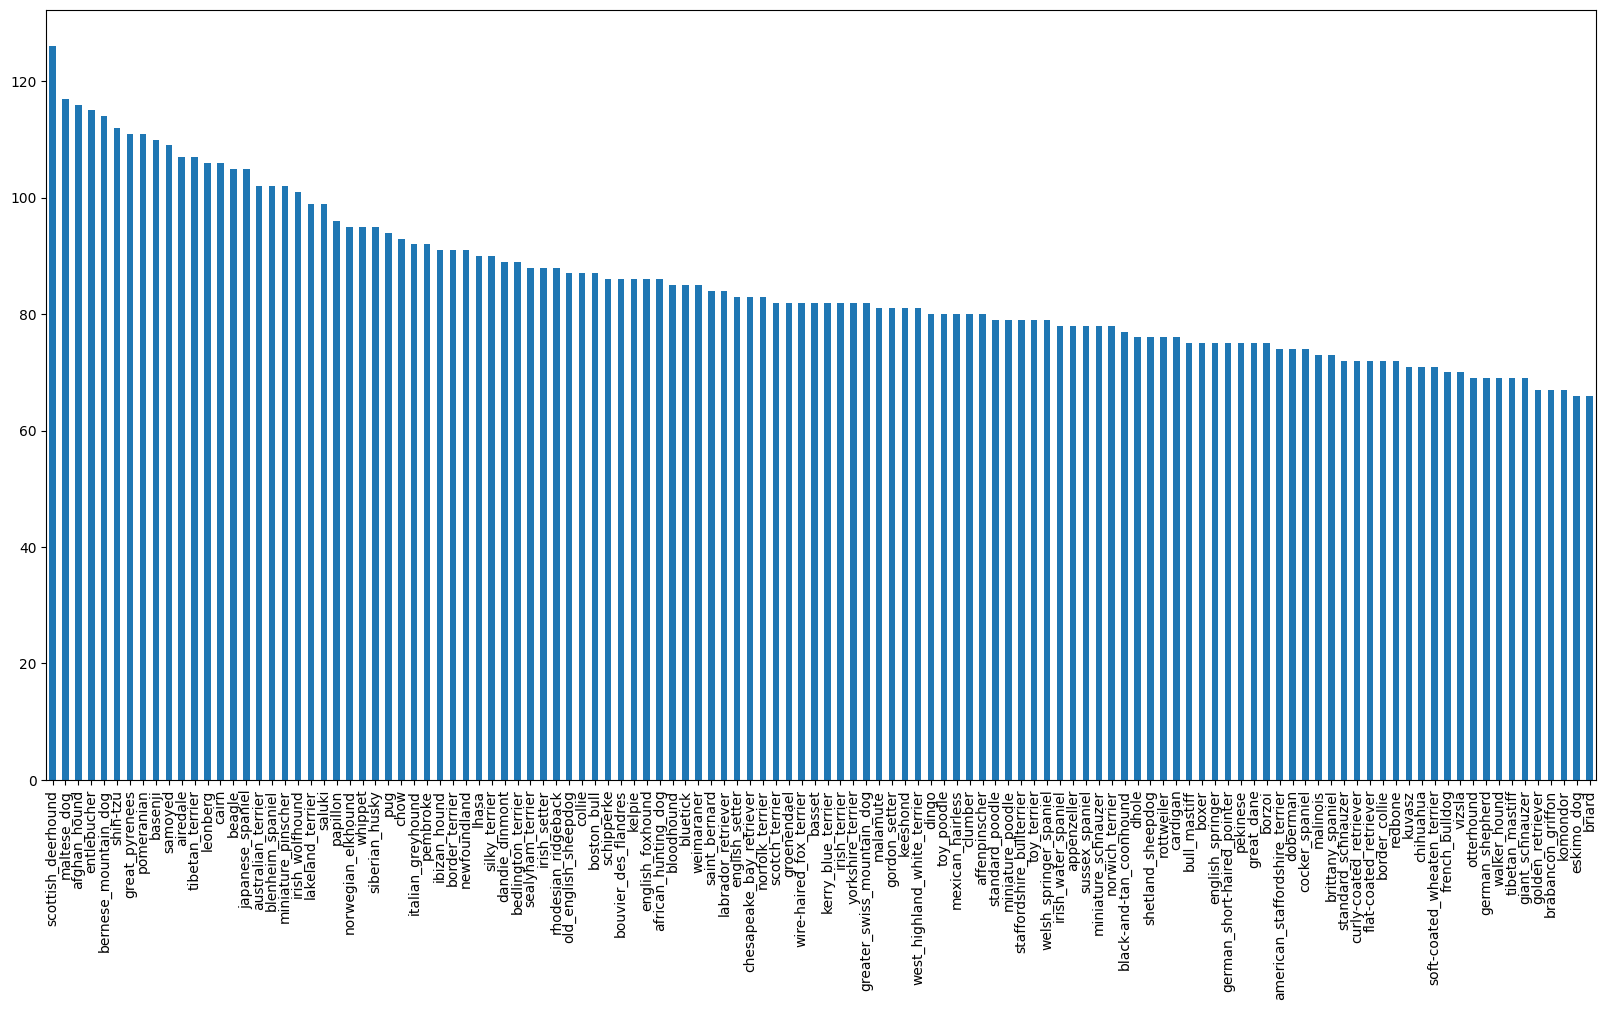

In [ ]:
label_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
label_csv["breed"].value_counts().median()

# 82 images per class median

82.0

## Let's view some images

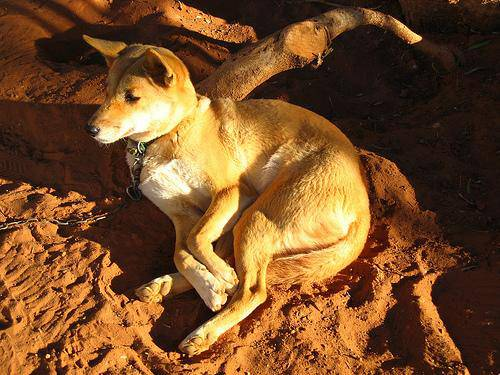

In [ ]:
from IPython.display import display, Image
Image("/content/drive/MyDrive/dog_vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

In [ ]:
label_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/dog_vision/train/" + fname + ".jpg" for fname in label_csv["id"]]

# Check the first 10 filenames
filenames[:10]

# **NOTE:** Filepaths are strings

['/content/drive/MyDrive/dog_vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/dog_vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/dog_vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/dog_vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/dog_vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/dog_vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/dog_vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/dog_vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/dog_vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/dog_vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
filenames[:5]

['/content/drive/MyDrive/dog_vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/dog_vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/dog_vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/dog_vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/dog_vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [ ]:
# Check wheter number of filenames matches number of actual image files

import os
if len(os.listdir("/content/drive/MyDrive/dog_vision/train/")) == len(filenames):
  print("Filenames match actual amount of files! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files! Proceed.


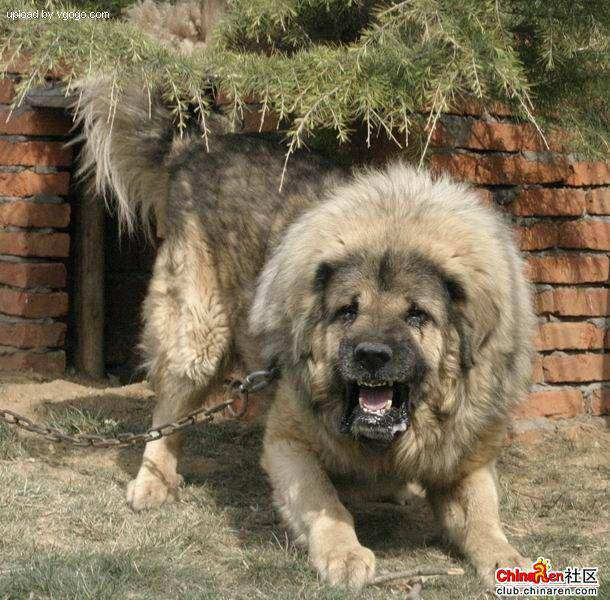

In [ ]:
# Check an image directly from a filepath
Image(filenames[9000])

In [ ]:
label_csv["breed"][9000]

'tibetan_mastiff'

Since we've got our training image filepath in a list, let's prepare our labels.


In [ ]:
import numpy as np


labels = label_csv["breed"].to_numpy()
# or labels = np.array(labels)
labels

# **NOTE:** In this case, labels are an array of string

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# Checking if number of labels matches the number of filenames

if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")
else:
  print("Number of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames


In [ ]:
unique_breeds = np.unique(labels)
unique_breeds
len(unique_breeds)

120

In [ ]:
# Now let's Turn a single label into an array of booleans

print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turning every label into boolean array

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Exemple - Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # Index where label occurs
print(boolean_labels[0].argmax()) # Index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # There will be a '1' Where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].argmax())
print(boolean_labels[2].astype(int))

pekinese
85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating a validation set

Since Kaggle's dataset doesn't come with a validation set, we are going to create one.


In [ ]:
# Setup X & y variables

X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

Starting off experimenting with ~1000 images and increase as needes

In [ ]:
# Set number of images to use for experimenting

NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:100}

In [ ]:
# Split out our data into train & validation sets

from sklearn.model_selection import train_test_split

# Split them into training & validation of total size NUM_IMAGES

# np.random.seed(42)

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
X_train[:5], y_train[:5]

(['/content/drive/MyDrive/dog_vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/dog_vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/dog_vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/dog_vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/dog_vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fals

## Preprocessing Images - Turning images into Tensor

In order to preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, 'image'
3. Turn 'image' (jpg) into Tensors
4. Normalize image (convert color channel values from 0-255 to 0-1)
5. Resize the 'image' to be a shape of(244, 244)
6. Return the modified 'image'

Before we do so, let's see what importing an image looks like...


In [ ]:
# Convert image to NumPy array

from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [ ]:
# Difference in Tensor

tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [ ]:
IMG_SIZE = 224

# Creating a function for preprocessing images

def process_image(image_filepath, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor
  """
  # Read the 'image' file

  image = tf.io.read_file(image_filepath)

  # Turn 'image' (jpg) into numerical Tensor with 3 colour channels (RBG)

  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the colour channel values from 0-255 to 0-1 values

  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the 'image' to be a shape of(244, 244)

  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  # Return the modified 'image'


  return image


## Turning data into batches

There are several reasons why we turn our data into batches.

* **Memory efficiency:** When we train a machine learning model, we need to store the data in memory. If we have a large dataset, this can be very memory-intensive. By batching the data, we can reduce the amount of memory required to train the model.

* **Computational efficiency:** Training a machine learning model can be computationally expensive. By batching the data, we can reduce the number of times we need to perform computations, which can save us time.

* **Improved accuracy:** Batching the data can also improve the accuracy of our machine learning model. This is because when we train the model on batches of data, we can get a more representative sample of the entire dataset.
In general, batching is a good idea when we have a large dataset and we want to train a machine learning model efficiently and accurately.

We're going to use batches of 32 images at a time

In [ ]:
# Creating a simple function to return a tuple (image, label)

def get_image_label(image_filepath, label):
  """
  Takes an image filepath name and the associated label,
  processes the image and then return a tuple of (image, label)
  """

  image = process_image(image_filepath)
  return image, label

# Creating a function  to turn all of our data, in the form : `(image, label)`into batches `(X & y)`

In [ ]:
# Define a batch size of 32

BATCH_SIZE = 32
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image (X) and label (y) pairs.
  It shuffles the data if it's training data but doesn't shuffle if it's
  validation data.
  Also accepts test data as input(no labels)
  """

  # If the data is a test dataset, we probably don't have labels

  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Creating atraining and validation  data batches

train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Now we have our data in batches, let's visualize them

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays 25 images from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn gird lines off
    plt.axis("off")

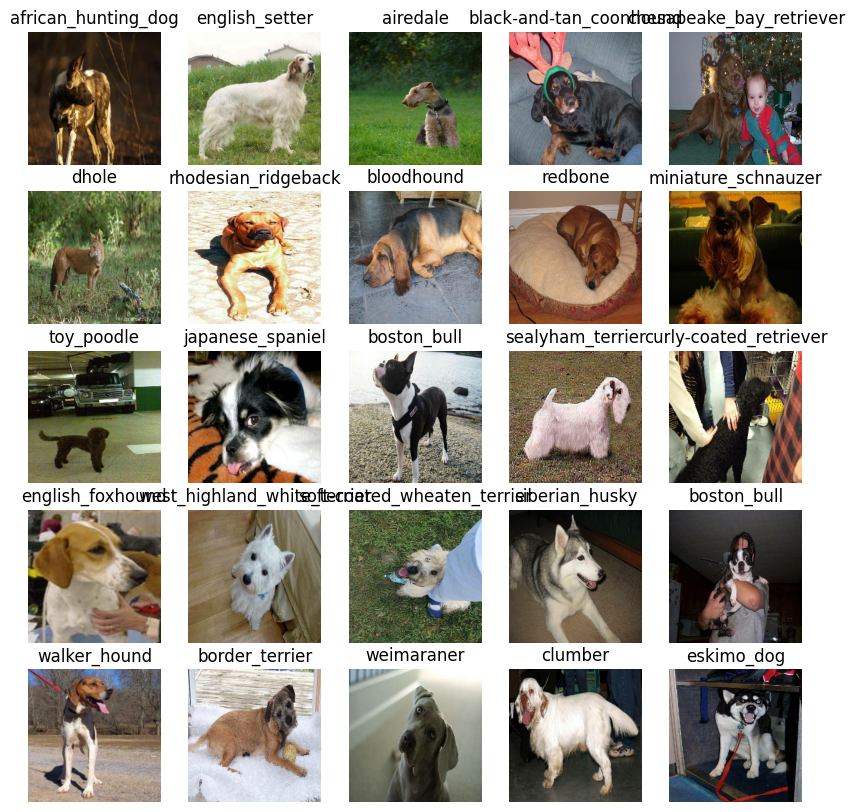

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

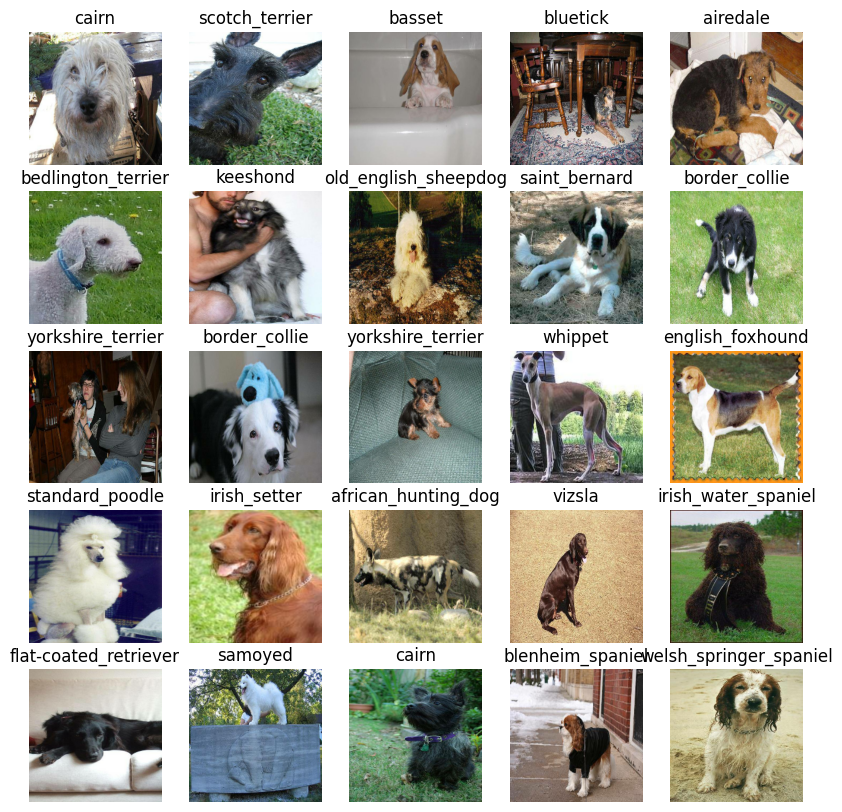

In [ ]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## BUILDING A MODEL

* The input shape (image shape in the form of Tensors)

* Output shape (image labels, in the form of Tensors)

* The URL of the model we want to use


In [ ]:
# Setup input shape to the model

INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Batch, height, width, colour channels

# Setup outputo the model

OUTPUT_SHAPE = len(unique_breeds)

# Setup model

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we're going to put our inputs, outputs and model together into a Keras deep learning model.

Let's create a function which:
* Takes the input shape, output shape and the model we have choosen as parameters.

* Defines the layers in a Keras model in sequential fashion -> Do this, then this, then that.

* Compile the model.

* Builds the model.

* Return the model.

These steps can be found: https://www.tensorflow.org/guide/keras

In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("building model with", MODEL_URL)

  # SETUP THE MODEL LAYERS

  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Layer 1 (Input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation="softmax") # Layer 2 (Output layer)
  ])

  # COMPILE THE MODEL

  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )


  # BUILDS THE MODEL

  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating callbacks

Callbacks are helpefull functions a model can use during training.

We'll createtwo callbacks:

1. One for TensorBoard, which helps track our models progress
2. Another for early stopping which prevents from training for too long.

### TensorBoard

1. Load TensorBoard.
2. Create a TensorBoard callback which is able to save logs to a directory and then pass it to our model's fit() function.
3. Visualize our models training logs with the %tensorboard function.

In [ ]:
# Load TensorBoard notebook extension

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime

# Function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/dog_vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Helps to Stop training when a monitored metric has stopped improving.

https://keras.io/api/callbacks/early_stopping/

In [ ]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
print("GPU", "available (YES!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU not available :(


### 🤖 Now it's time to create a function which trains a model

1. `create_model()`

2. `create_tensorboard_callback()`

3. Call `fit()` function on our model passing it the training data, validation data, number of epochs and the callbacks we would like to use
4. Returns the model


In [ ]:
# Building a function to train and return a trained model

def train_model():
  """
  Trains a model and returns the trained version
  """

  # Creating a model

  model = create_model()

  # Creating new TensorBoard session everytime we need to train a model

  tensorboard = create_tensorboard_callback()


  # Fitting the model to the data passing it the callbacks we have created

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])

  return model

In [ ]:
model = train_model()

building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100


KeyboardInterrupt: 

**Note:** Our model is overfitting because it's performing far better on the training dataset than the validation dataset.

### Let's check our TensorBoard logs

`%tensorboard` will acces the logs directory we have created earlier and visualize its contentes

In [ ]:
#%tensorboard  --logdir /content/drive/MyDrive/dog_vision/logs

### Now let's make some predictions and evaluate them using a trained model

In [ ]:
# Make predictions on the validation data (not used to train)

predictions = model.predict(val_data, verbose=1)
predictions

KeyboardInterrupt: 

In [ ]:
predictions.shape

In [ ]:
# First prediction
index = 42
print(predictions[index])
print(f'Max value (probability of prediction) : {np.max(predictions[index])}')
print(f'Sum : {np.sum(predictions[index])}')
print(f'Max index : {np.argmax(predictions[index])}')
print(f'Predicted label : {unique_breeds[np.argmax(predictions[index])]}')

### Visualize the prediction

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
# A function to turn prediction probabilities into their respective label

def get_pred_label(predictions_probabilities):
  """
  Turns an array of prediction prop into a label
  """

  return unique_breeds[np.argmax(predictions_probabilities)]

pred_label = get_pred_label(predictions[42])
pred_label

NameError: name 'predictions' is not defined

In [ ]:
# Function to unbatch a batch dataset

def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

KeyboardInterrupt: 

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we have got some functions to help us visualize our predictions and evaluate our model.

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

### Saving and reloading a trained model

In [ ]:
# Function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/dog_vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path


In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

### Testing Functions

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model('/content/drive/MyDrive/dog_vision/models/20240115-14101705327856-1000-images-mobilenetv2-Adam.h5')


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

### Training Model on Full Dataset

In [ ]:
len(X), len(y)

In [ ]:
# Creating a data batch with the full data set
full_data = create_data_batches(X, y)

In [ ]:
full_data

In [ ]:
# Creating a model fo full test

full_model = create_model()

In [ ]:
# Creating a full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [ ]:
# Fitting the full model to the full data
#full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

In [ ]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")


In [ ]:
# Load in the full model
loaded_full_model = load_model('/content/drive/MyDrive/dog_vision/models/20240115-14551705330532-full-image-set-mobilenetv2-Adam.h5')


## Making predictions on the Test Dataset

Since our model has been trained on images in the form of Tesor batches, to make predictions on the test data, we will have to get it into the same format.

Luckily, we have created `create_data_batches()` function earlier which can take a list of filenames as input and covert then into Tensor batches.

To make predictions on the test data, we are going to need to:
* Get the test image filenames
* Convert filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True`
* Make predictions array by passing the test batches to the `predict()` method called on our model.

In [ ]:
# Load test image filenames
test_path = "/content/drive/MyDrive/dog_vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]


In [ ]:
len(test_filenames)

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)



In [ ]:
test_data

In [ ]:
# Make predictions on test data batch using the loaded full model

# test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)


In [ ]:
# Saving predictions (NumPy array) to CSV file (For later access)

np.savetxt("drive/MyDrive/dog_vision/preds_array.csv", test_predictions, delimiter=",")


In [ ]:
test_predictions = np.loadtxt("/content/drive/MyDrive/dog_vision/preds_array.csv", delimiter=",")


In [ ]:
test_predictions[:10]

In [ ]:
test_predictions.shape

### Preparing Test dataset to Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
list(unique_breeds)
["id"] + list(unique_breeds)

In [ ]:
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

In [ ]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

In [ ]:
preds_df[list(unique_breeds)] =  test_predictions
preds_df.head()

In [ ]:
preds_df.to_csv("/content/drive/MyDrive/dog_vision/full_model_predictions_submission_1_mobilenetv2.csv",
                index=False)

### Making predictions on custom images

The most exciting part of the project

* Get the filepaths of our own images.
Turn the filepaths into data batches using function `create_data_batches()`
* Pass the custom image data batch to our model's `predict()` method
*Convert the prediction output probabilities to predictions labels
* Compare the predicted labels to the custom images

In [ ]:
# Get custom image filepaths
custom_path = "drive/MyDrive/dog_vision/my_dog_photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]


In [ ]:
# let's turn custom image into batch (set to test data because there are no labels)

custom_data = create_data_batches(custom_image_paths, test_data=True)

In [ ]:
# Time to make predictions on the custom data

custom_preds = loaded_full_model.predict(custom_data)

It returned some predictions arrays. We need to convert them into labels and compare them with each image.

In [ ]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

# Next Steps

Our model is working!
Using this approach we can beat lots of multi-class image classification problem, using different data.

We can improve our model:

1. Trying another model from TF Hub
2. We can try Data Augmentation technique
3. Fine tune our model.